In [879]:
import control as co
import numpy as np

V_IN, V_OUT = 5, 170
R_LOAD, C_OUT, L_m = 170 * 33, 6.6e-6, 10e-6
V_Q, V_D = 0.8, 0.76
V_IN -= V_Q
V_OUT -= V_D
N_PS = 10
D = V_OUT * (1 / N_PS) / (V_IN + V_OUT * 1 / N_PS)
f_sw = 130e+3
R_FA = 4.503 * (10 ** 11) * f_sw ** -1.26
T = 1 / f_sw

V_SL = 92e-3
R_i = 0.01 # 외부 션트 저항
S_n = V_IN / L_m
S_f = V_OUT / (L_m * N_PS)
S_e = V_SL * f_sw / R_i
F_m = 1 / ((S_n + S_e) * T)
H_di = co.tf([C_OUT * V_IN / (1 - D), 1 / R_LOAD * (V_IN / (1 - D) + V_IN * D * N_PS)], [L_m * C_OUT, L_m / R_LOAD, (V_IN * D / V_OUT) ** 2])
H_e = co.tf([1 / ((np.pi / T) ** 2), -1 / (2 / T), 1], [1])
H_ivo = N_PS * co.tf([-L_m * V_OUT / (V_IN * R_LOAD), 1], [1]) / co.tf([C_OUT / (1 - D), 1 / R_LOAD * (1 / (1 - D) + D * N_PS)], [1])

V_ref = 1.26
R_FB1 = 330e+3
R_FB2 = V_ref * R_FB1 / (V_OUT - V_ref)
H_div = R_FB2 / (R_FB1 + R_FB2)

g_m = 800e-6
A_EA = 38
R_OUT_COMP = A_EA / g_m

# f_p2, f_z3 = 10 ** 0.5, 10 ** 2.5
# w_p2, w_z3 = 2 * np.pi * f_p2, 2 * np.pi * f_z3
# R_C1 = f_p2 * R_OUT_COMP / (f_z3 - f_p2)
# C_C1 = 1 / (2 * np.pi * f_z3 * R_C1)
# G_EA = A_EA * co.tf([1 / w_z3, 1], [1 / w_p2, 1])

G_fc = -65
G = 10 ** (G_fc / 20)
f_z_ea, f_p_ea = 10 ** 0, 10 ** 1
f_c_ea = np.sqrt(f_z_ea * f_p_ea)
w_z_ea, w_p_ea, w_c_ea = 2 * np.pi * f_z_ea, 2 * np.pi * f_p_ea, 2 * np.pi * f_c_ea
a = np.sqrt(1 + (f_c_ea / f_p_ea) ** 2)
b = np.sqrt(1 + (f_z_ea / f_c_ea) ** 2)
R_2 = f_p_ea * G * (R_FB2 + R_FB1) / ((f_p_ea - f_z_ea) * R_FB2 * g_m) * a / b
C_1 = 1 / (2 * np.pi * f_z_ea * R_2)
C_3 = R_FB2 * g_m / (2 * np.pi * f_p_ea * G * (R_FB2 + R_FB1))
G_0 = R_FB2 / (R_FB1 + R_FB2) * g_m * R_2 * C_1 / (C_1 + C_3)
G_EA = G_0 * (1 + co.tf([w_z_ea], [1, 0])) / co.tf([1 / w_p_ea, 1], [1])

PS = F_m * H_di * H_ivo / (1 + H_e * R_i * F_m * H_di)

G_loop = PS * G_EA


In [880]:
print(R_FA)
print(D)
print(R_FB1, R_FB2)


162156.1121043717
0.8011740200719563
330000.0 2475.2946779378494


In [881]:
print((S_f - S_e) / (S_n + S_e) < 1)
# print(S_e > (S_f - S_n) / 2)
print(S_e, (S_f - S_n) / 2)

True
1196000.0 636200.0


In [882]:
# print(R_C1, C_C1)
print(R_2, C_1, C_3, R_FB1, R_FB2)


104.9059147654483 0.0015171207786304384 0.00016856897540338205 330000.0 2475.2946779378494


In [883]:
print(G_loop)


<TransferFunction>: sys[3818]
Inputs (1): ['u[0]']
Outputs (1): ['y[0]']


                  -2.99e-25 s^5 + 4.163e-18 s^4 + 4.283e-16 s^3 + 2.494e-11 s^2 + 1.903e-09 s + 1.097e-08
---------------------------------------------------------------------------------------------------------------------------
2.345e-35 s^8 + 2.286e-27 s^7 + 4.337e-24 s^6 + 2.841e-20 s^5 + 2.789e-17 s^4 + 8.754e-14 s^3 + 1.129e-11 s^2 + 3.705e-10 s



In [884]:
print(co.poles(G_loop))


[-9.75108747e+07   +0.j         -8.68601526e+02+2322.60449675j
 -8.68601526e+02-2322.60449675j -1.35040242e+01+2447.34137528j
 -1.35040242e+01-2447.34137528j -7.00303056e+01   +0.j
 -6.28318531e+01   +0.j          0.00000000e+00   +0.j        ]


c:\Users\akswnd98\anaconda3\Lib\site-packages\control\freqplot.py:1440: UserWarning: number of encirclements was a non-integer value; this can happen is contour is not closed, possibly based on a frequency range that does not include zero.
  warnings.warn(


array([list([<matplotlib.lines.Line2D object at 0x00000223E14C8610>, None, <matplotlib.lines.Line2D object at 0x00000223E14C9990>, None])],
      dtype=object)

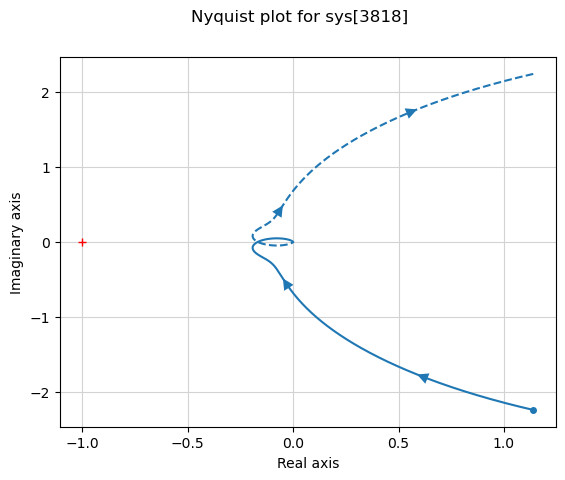

In [885]:
omega = np.linspace(100, 1000000, 1000000)
co.nyquist_plot(G_loop, omega=omega, max_curve_magnitude=1e18)


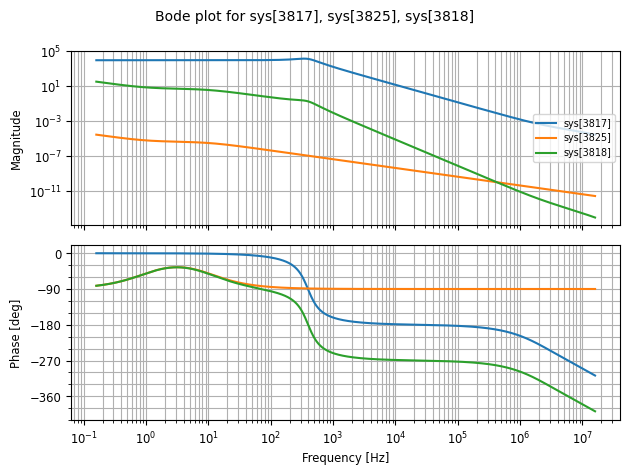

In [886]:
omega = np.logspace(0, 8, 10000)
mag, phase = co.bode(PS, np.logspace(0, 8, 10000), Hz=True)
mag, phase = co.bode(G_EA * H_div, np.logspace(0, 8, 10000), Hz=True)
mag, phase = co.bode(G_loop, np.logspace(0, 8, 10000), Hz=True)
